In [1]:
from ipywidgets import interact
from fastai.basics import *

At its core, deep learning seeks to produce a mathematical function that most closely approximates the values we expect in a given situation.

For example, we can construct a quadratic function with known parameters a,b,c and plot it, then make another quadratic starting with random values for parameters a,b,c and blindly tinker with their values until you hit the closest match. You can do this visually or with a loss function which tells us how close we are, mean squared error in this case.

In [6]:
def quadratic(x: Tensor, params: Tensor):
    a, b, c = params
    return a*x**2 + b*x + c

def make_quadratic(params: Tensor):
    return partial(quadratic, params=params)

def mean_squared_error(actual: Tensor, tinker: Tensor):
    return ((tinker - actual)**2).mean()

original_params = torch.tensor([3., 2., 1.])
quad = make_quadratic(params=original_params)

times = torch.arange(-10, 10).float()

@interact(a=1.1, b=1.1, c=1.1)
def plot_quadratic(a: float, b: float, c: float):
    plt.figure()
    plt.plot(times, quad(times))
    tinker_quad = make_quadratic(params=torch.tensor([a, b, c]))
    plt.title(f"MSE {round(mean_squared_error(quad(times), tinker_quad(times)).item(), 2)}")
    plt.plot(times, tinker_quad(times))

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

This is basically what a deep learning model does, except we systematize the guesses to do it extremely quickly. We can use gradients to determine which direction, and relatively how much, we should move each parameter.

Here, we create a set of random initial training parameters with gradient calculation enabled. Then, we go through the training cycle:
  1. Calculate the prediction based on our params
  2. Calculate the loss on this prediction
  3. Calculate the gradients on these parameters
  4. Adjust our parameters based on the gardients times the learning rate
  5. Repeat

tensor(2558.5718, grad_fn=<MeanBackward0>)
tensor(21.5210, grad_fn=<MeanBackward0>)
tensor(8.5803, grad_fn=<MeanBackward0>)
tensor(4.9863, grad_fn=<MeanBackward0>)
tensor(3.9549, grad_fn=<MeanBackward0>)
tensor(3.6265, grad_fn=<MeanBackward0>)
tensor(3.4917, grad_fn=<MeanBackward0>)
tensor(3.4107, grad_fn=<MeanBackward0>)
tensor(3.3453, grad_fn=<MeanBackward0>)
tensor(3.2848, grad_fn=<MeanBackward0>)


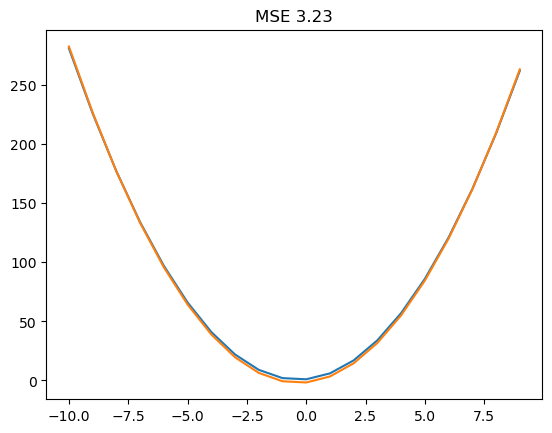

In [17]:
def quadratic(x: Tensor, params: Tensor):
    a, b, c = params
    return a*x**2 + b*x + c

def mean_squared_error(actual: Tensor, prediction: Tensor):
    return ((prediction - actual)**2).mean()

times = torch.arange(-10, 10).float()

actual_params = torch.tensor([3., 2., 1.])
actual = quadratic(times, actual_params)
training_params = torch.randn(3, requires_grad=True)

learning_rate = 0.0001

for i in range(1000):
    prediction = quadratic(times, training_params)
    loss = mean_squared_error(actual, prediction)
    if i % 100 == 0: print(loss)
    loss.backward()  # AKA calculate gradient
    training_params.data -= training_params.grad.data * learning_rate  # type: ignore (pylance doesn't understand loss.backward was called)
    # Note grad has to be reset or it accumulates between cycles and produces incorrect data
    training_params.grad = None

plt.figure()
plt.plot(times, actual)
plt.title(f"MSE {round(mean_squared_error(actual, prediction).item(), 2)}")
# Note these will be so close together they may be overlapping/second invisble
plt.plot(times, prediction.detach().numpy())

The last piece to understand here is how we calculate the gradients.

The gradients are based on the **derivative of the loss function with respect to each variable**.

To calculate the derivative of a multivariate function, we take the partial derivative of the loss function for each variable, holding the remainder constant.

Below is an example of getting the derivative of the loss function with respect to a, holding b and c constant. Note that the quadratic function and the loss function both appear the same on a graph because they are both quadratic formulae, but they are separate graphs. The function has x of time and y of speed, while the loss function has x of paramater value and y of loss.

Here we are getting every loss within a range of values of the paramater a, then plotting the minimum.

Ultimately, all the gradient is doing is taking the partial derivative with respect to each variable, holding the others constant. It tells you which way to move each and approximately how much based on this.

Text(0.5, 1.0, 'Loss function with min loss at: (3, 0.0)')

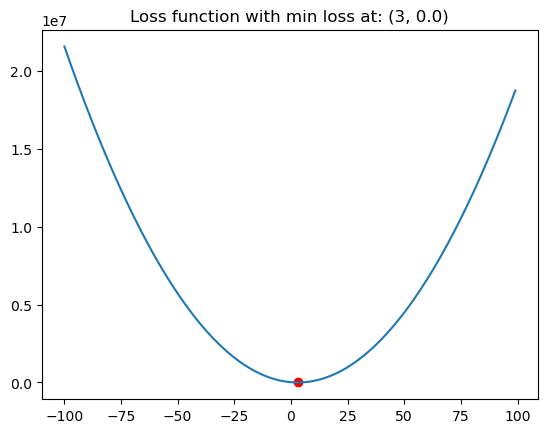

In [13]:
times = torch.arange(-10, 10).float()

def quadratic(x: Tensor, params: Tensor):
    a, b, c = params
    return a*x**2 + b*x + c

def mean_squared_error(actual: Tensor, training_params: Tensor):
    prediction = quadratic(times, training_params)
    return ((prediction - actual)**2).mean()

actual_params = torch.tensor([3., 2., 1.])
actual = quadratic(times, actual_params)

times = torch.arange(-10, 10).float()

learning_rate = 0.0001

losses = []

parameter_a_tests = range(-100, 100)

for parameter_a in parameter_a_tests:
    losses.append(
            mean_squared_error(
                actual,
                torch.tensor([float(parameter_a), 2., 1.])
            )
        )

min_loss_idx = np.argmin(losses)

plt.figure()
plt.plot(parameter_a_tests, losses)
plt.scatter(parameter_a_tests[min_loss_idx], losses[min_loss_idx], color='red')
plt.plot()
plt.title(f"Loss function with min loss at: {parameter_a_tests[min_loss_idx], losses[min_loss_idx].item()}")
